# Figures XX: 8 class models

This notebook will reproduce Figures YY from *Heuristic Methods for Determining the Number of Classes in Unsupervised Classification of Climate Models*, E. Boland et al. 2022 (doi to follow). This plots the properties of 8 class GMMs fit to UK-ESM historical Southern Ocean data 2001-2018, following Jones et al. 2019 (https://doi.org/10.1029/2018JC014629). This requires the files data/\[ensemble member\]/\[nclass\]/avg.obj, created by running calculate_8classes_20012017.ipynb.

Please attribute any plots or code from this notebook using the DOI from Zenodo: to come

Updated Nov 2022
E Atkinson & E Boland [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import scipy.stats as sts

import os
import pickle

import cluster_utils as flt

In [12]:
model_folder = 'model_20012017'
n_classes = [8,]
ids = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2']
#ids = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r5i1p1f3', 'r6i1p1f3', 'r7i1p1f3', 'r8i1p1f2', 'r9i1p1f2', 'r10i1p1f2'] # You need all of these for figs YY
mask = np.load('data/mask.npy', allow_pickle=True)
levs= np.load('data/levs_52000.npy', allow_pickle=True)

In [4]:
# Load fronts
fronts=['saf','pf','saccf','sbdy']
front_data={}
for front in fronts:
    front_data[front]=np.loadtxt('data/fronts/{}_kim.txt'.format(front))

In [13]:
data_ids=[]
for m_id in ids:
    data_classes=[]
    for nn in n_classes:
        path='{}/{}/{}'.format(model_folder, m_id, nn)
        data=xr.open_dataset('{}/class.nc'.format(path)) 
        with open('{}/avg_prof.obj'.format(path), 'rb') as file:
            ref_profiles = pickle.load(file)
        inds=flt.temp_sort(None, ref_profiles, True)
        data=flt.reorder(data,inds)
        mean_data=np.vstack([ref_profiles[i]['mean'] for i in range(0,len(ref_profiles))])
        mean_data_sorted=mean_data[inds]
        data=data.assign(profile_mean=xr.DataArray(data=mean_data_sorted,dims=['classnum','lev'],coords=dict(classnum=np.arange(0,nn),lev=levs)))
        std_data=np.vstack([ref_profiles[i]['std'] for i in range(0,len(ref_profiles))])
        std_data_sorted=std_data[inds]
        data=data.assign(profile_std=xr.DataArray(data=std_data_sorted,dims=['classnum','lev']))
        data_classes.append(data)
    data_ids.append(data_classes)
classes=xr.combine_nested(data_ids,['run','nclasses'])

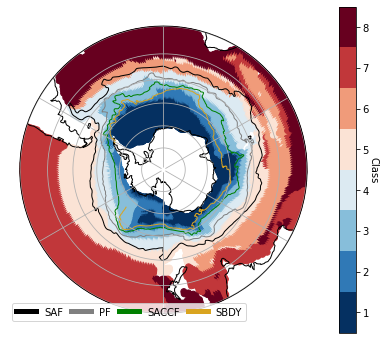

In [14]:
import cartopy.crs as ccrs
import matplotlib.path as mpath
n_classes=8
proj = ccrs.SouthPolarStereo()
front_colors=['black','grey','green',(218/256,165/256,32/256)]
colormap = plt.get_cmap('RdBu_r', n_classes)

fig=plt.figure(figsize=(7,6))

ax = plt.subplot(1,1,1,projection=proj)
    
CS=ax.scatter(classes.lon,classes.lat,c=flt.modal_classes(classes['class'].sel(nclasses=n_classes),dims=['time','run']),cmap=colormap,transform=ccrs.PlateCarree())
for indf,front in enumerate(fronts):
    ax.plot(front_data[front][:,0], front_data[front][:,1], lw = 1, ls='-', label=front.upper(),color=front_colors[indf],transform=ccrs.PlateCarree())

#leg = ax.legend(bbox_to_anchor=( 1.25,1.2), ncol=4, \
#                         columnspacing = 0.8)
leg = ax.legend(ncol=4, columnspacing = 0.8)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

# compute a circle in axes coordinates, 
# which we can use as a boundary for the map.
theta = np.linspace(0, 2*np.pi, 100)
center = [0.5, 0.5]
radius = 0.46   # 0.46 corresponds to roughly 30S Latitude
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)

# Add features
ax.gridlines()
#ax.add_feature(cfeature.LAND)
ax.coastlines()

colorbar = plt.colorbar(CS)
dclass=(n_classes-1)/n_classes
cticks = np.arange(dclass/2, n_classes-1, dclass)
clabels=np.arange(1,n_classes+1,1)
colorbar.set_ticks(cticks)
colorbar.set_ticklabels(clabels)
colorbar.set_label('Class', rotation=270, labelpad=10)

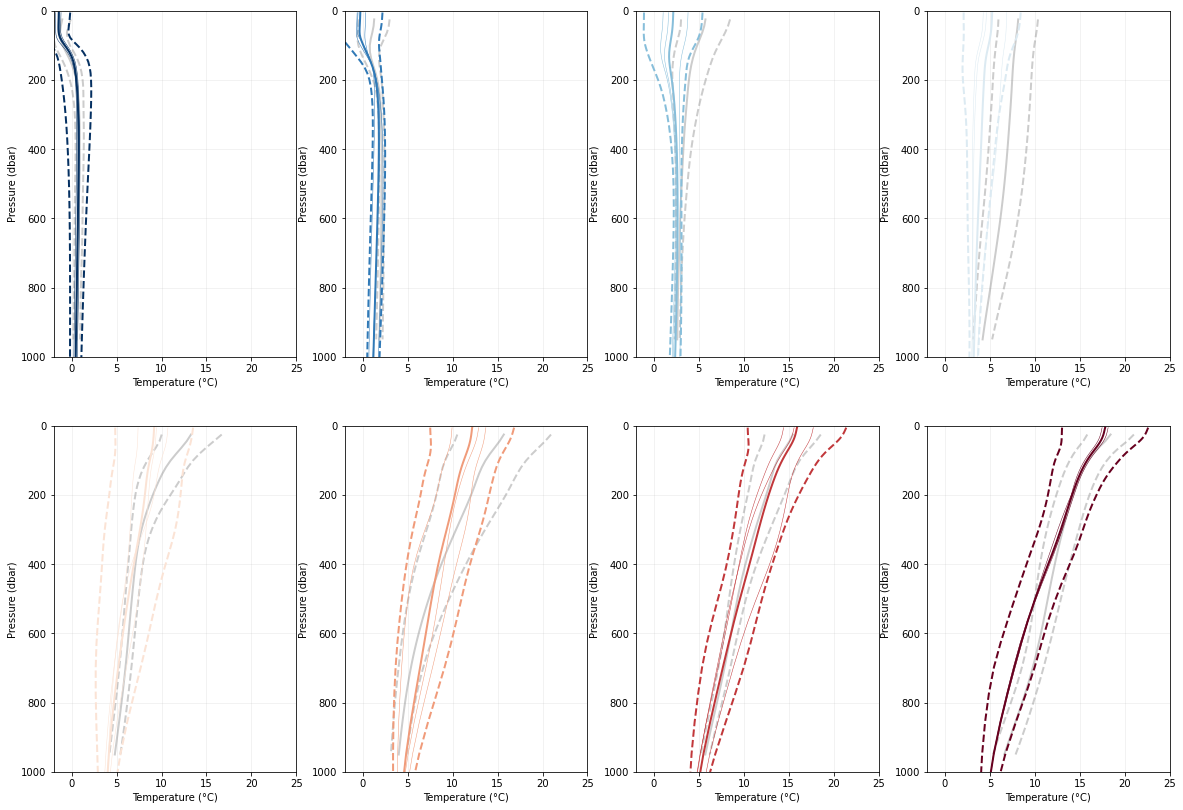

In [16]:
from scipy.interpolate import interp1d
n_classes=8
cmap = plt.get_cmap('RdBu_r', n_classes)
ls=['-','--','--']
fig = plt.figure(figsize=(20,14))
    # loop through all classes, get mean/std temperature of profiles
for k in range(0,n_classes):

    ax = plt.subplot(2,4,k+1)
    path='{}/{}/{}'.format(model_folder, m_id, nn)  
    with open('{}/avg_prof.obj'.format(path), 'rb') as file:
        ref_profiles = pickle.load(file)
    inds=flt.temp_sort(None, ref_profiles, True)    
        # calculate statistics of those profiles at each pressure level
    Tmean = classes['profile_mean'].sel(nclasses=n_classes,classnum=k)
    Tsig = classes['profile_std'].sel(nclasses=n_classes,classnum=k)
    
    # Jones et al data
    my_data = np.genfromtxt('Jones2019_data/Figure06_class{}.csv'.format(k+1), delimiter=',')
    npoints=int(my_data.shape[0]/3)
    ncols=int(my_data.size/3/npoints)
    curves=np.reshape(my_data,[npoints,3,ncols])
    for curve in range(0,3):
        x=curves[:,curve,0]
        y=curves[:,curve,1]
        cubic = interp1d(y, x,kind='cubic')
        YY=np.linspace(25,950,50)
        XX=cubic(YY)
        plt.plot(XX,YY,linestyle=ls[curve],color='grey',axes=ax,linewidth=2,alpha=0.4)   
    
    # create plot
    plt.plot(Tmean.T, levs, color=cmap(k), linestyle='solid', linewidth=0.5)
    #plt.plot((Tmean-Tsig).T,levs, color=cmap(k), linestyle='dashed', linewidth=0.5)
    #plt.plot((Tmean+Tsig).T,levs, color=cmap(k), linestyle='dashed', linewidth=0.5)
    plt.plot(Tmean.mean('run'),levs, color=cmap(k), linestyle='solid', linewidth=2)
    plt.plot(Tmean.mean('run')+np.sqrt((Tsig**2).sum(dim='run')),levs, color=cmap(k), linestyle='dashed', linewidth=2)
    plt.plot(Tmean.mean('run')-np.sqrt((Tsig**2).sum(dim='run')),levs, color=cmap(k), linestyle='dashed', linewidth=2)

    # invert axes
    ax = plt.gca()
    ax.set_ylim(0,1000)
    ax.set_xlim(-2,25)
    ax.grid(alpha=0.2)
    ax.invert_yaxis()
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Pressure (dbar)')

        # save and show the plot 
#plt.savefig(address + 'Plots/Tprof_by_pressure_class' + \
#                    str(k).zfill(3) + '.pdf', bbox_inches="tight", \
#                    transparent=True)


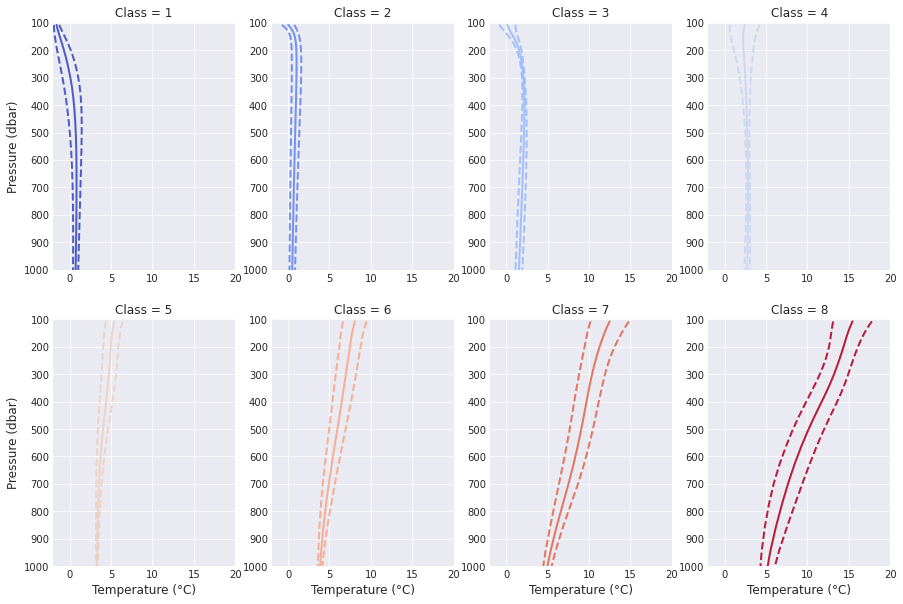

In [43]:
# initialize the figure
plt.figure(figsize=(15, 10))
plt.style.use('seaborn-darkgrid')

# create a color palette
from matplotlib.pyplot import cm
palette = cm.coolwarm(np.linspace(0,1,n_classes))

fs = 12 # font size
# iterate over groups
for nn in range(0,n_classes):
    
    # extract means
    mean_T = ref_profiles[inds[nn]]['mean']
    std_T = ref_profiles[inds[nn]]['std']
    
    # select subplot
    plt.subplot(2,4,nn+1)
    plt.plot(mean_T, levs, marker='', linestyle='solid', color=palette[nn], linewidth=2.0, alpha=0.9)
    plt.plot(mean_T+std_T, levs, marker='', linestyle='dashed', color=palette[nn], linewidth=2.0, alpha=0.9)
    plt.plot(mean_T-std_T, levs, marker='', linestyle='dashed', color=palette[nn], linewidth=2.0, alpha=0.9)
    
    # custom grid and axes
    plt.ylim([100,1000])
    ax = plt.gca()
    ax.invert_yaxis() 
    plt.xlim([-2, 20])
    ax.grid(True)
    
    if nn>3:
        plt.xlabel('Temperature (°C)', fontsize=fs)
    if np.mod(nn,4)==0:
        plt.ylabel('Pressure (dbar)', fontsize=fs)
    plt.title('Class = ' + str(nn+1), fontsize=fs)
    

Starting r1i1p1f2
Finished setup for r1i1p1f2
0


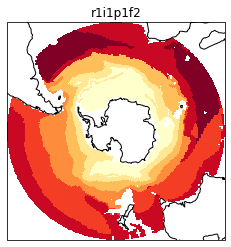

Starting r2i1p1f2
Finished setup for r2i1p1f2
0


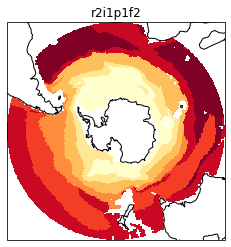

Starting r3i1p1f2
Finished setup for r3i1p1f2
0


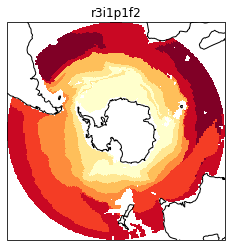

Starting r4i1p1f2
Finished setup for r4i1p1f2
0


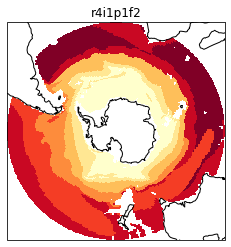

Starting r8i1p1f2
Finished setup for r8i1p1f2
0


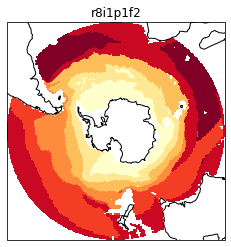

Starting r9i1p1f2
Finished setup for r9i1p1f2
0


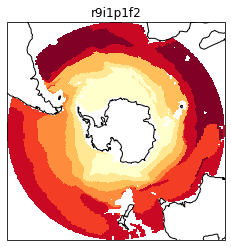

Starting r10i1p1f2
Finished setup for r10i1p1f2
0


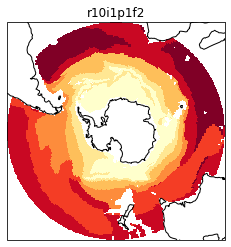

Done!


In [21]:
# Reference
avg_profiles_dict = {}
path_ref = '{}/{}/{}'.format(model_folder, ids[0], n_classes)
with open('{}/avg.obj'.format(path_ref), 'rb') as file:
    ref_profiles = pickle.load(file)
inds = flt.temp_sort(None, ref_profiles, True)
ref_profiles = [ref_profiles[x] for x in inds]
    
for (m_i, m_id) in enumerate(ids):

    print('Starting {}'.format(m_id))
    path_id = '{}/{}'.format(model_folder, m_id)
    path_n = '{}/{}/{}'.format(model_folder, m_id, n_classes)

    with open('{}/pca.obj'.format(path_id), 'rb') as file:
        pca = pickle.load(file)
        file.close()

    with open('{}/gmm.obj'.format(path_n), 'rb') as file:
        gmm = pickle.load(file)
        file.close()

    with open('{}/avg.obj'.format(path_n), 'rb') as file:
        avg_profiles = pickle.load(file)
        file.close()

  options = {'memberId' : m_id, 'raw' : True}
  data = flt.retrieve_profiles(timeRange = '2000-01', mask=mask, options=options)
  data_sampled = flt.normalise_data(data, ('i', 'j', 'time'))
  data_trans = flt.pca_transform(data_sampled, pca)
  data_c = flt.gmm_classify(data_trans, gmm)
  
  inds = flt.match_profiles(ref_profiles, avg_profiles)
  data_c = flt.reorder(data_c, inds).compute()
  
  avg_profiles = [avg_profiles[x] for x in inds]
  avg_profiles_dict[m_id] = avg_profiles
  print('Finished setup for {}'.format(m_id))
  
  # Make a plot
  
  lats = data_c['lat'].values
  lons = data_c['lon'].values
  lev = data['lev'].values

  plt_data = data_c.values
  alpha = np.logical_not(data.isel(time=0, lev=-1).isnull().values)
  #alpha = np.isin(data_c.isel(time=0).values, (3, 4, 5))
  plt_data[plt_data == -1] = 0
  for i in range(np.size(plt_data, 0)):
      print(i)
      ax = plt.subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
      ax.pcolormesh(lons, lats, plt_data[i, :, :], transform=ccrs.PlateCarree(), alpha=alpha, cmap='YlOrRd')
      ax.coastlines()
      ax.set_title(m_id)
      ax.set_facecolor('white')
      #plt.savefig('figures/{}-example'.format(m_id), dpi=600)
      plt.show()
      ax.clear()

    
print('Done!')

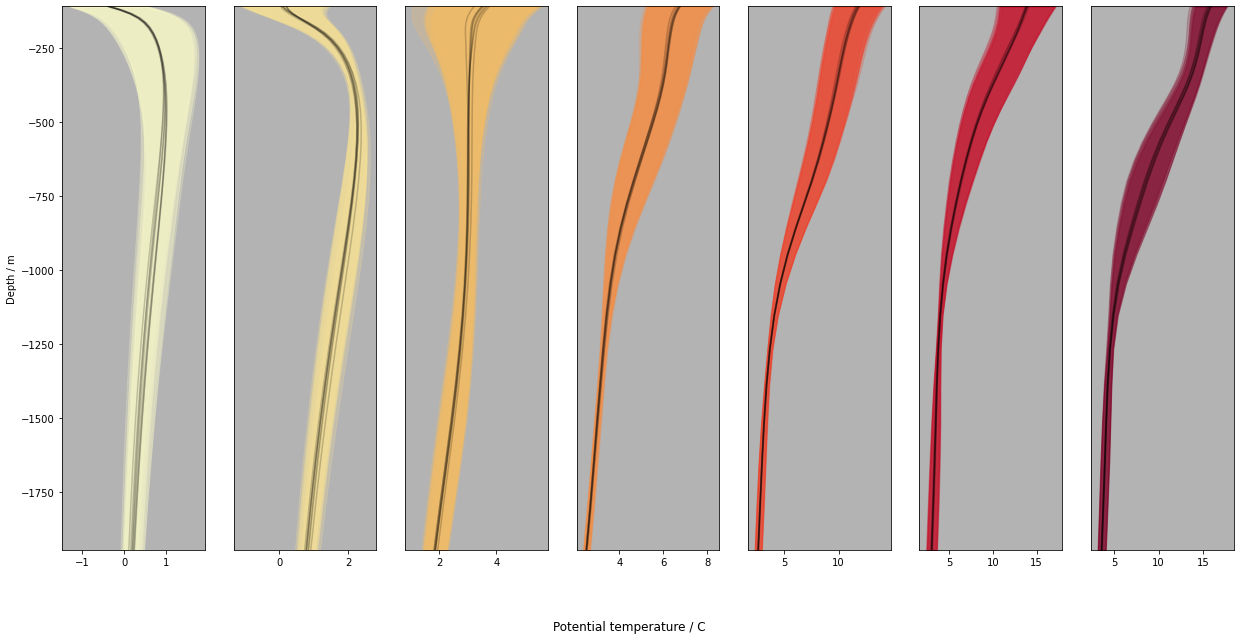

In [31]:
cmap = matplotlib.cm.get_cmap('YlOrRd')
fig, axes = plt.subplots(1, n_classes)
for (m_i, m_id) in enumerate(ids):
  for (n, ax) in enumerate(axes):
    if n > 0:
      ax.set_yticks([])
    else:
      ax.set_ylabel('Depth / m')
    ax.plot(avg_profiles_dict[m_id][n]['mean'], -lev, c='black', alpha=0.2)
    x1 = avg_profiles_dict[m_id][n]['mean'] + avg_profiles_dict[m_id][n]['std']
    x2 = avg_profiles_dict[m_id][n]['mean'] - avg_profiles_dict[m_id][n]['std']
    ax.plot(x1, -lev, c='black', ls='--', alpha=0.0)
    ax.plot(x2, -lev, c='black', ls='--', alpha=0.0)
    ax.fill_betweenx(-lev, x1, x2, color=cmap(n / (n_classes - 1)), alpha=0.2)
    
    #ax.set_xlabel('Potential temperature / C')
    ax.set_ylim(np.min(-lev), np.max(-lev))
    ax.set_facecolor((0.7, 0.7, 0.7, 1))
    
fig.supxlabel('Potential temperature / C')
fig.set_size_inches(3 * n_classes, 10)
plt.savefig('figures/profiles-example', dpi=300)